In [2]:
import torch
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.gp_regression import SingleTaskGP
import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt
import math

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [41]:

# Based on https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/Exact_GP_Posterior_Sampling_with_CIQ.html

# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1., 100).unsqueeze(1)
# True function is sin(2*pi*x)
train_y = torch.sin(train_x * (2 * math.pi))  + torch.randn(train_x.size()) * 0.2

kernel = ScaleKernel(
    base_kernel=RBFKernel(
        ard_num_dims=1,
        # lengthscale_prior=GammaPrior(3.0, 6.0) # This is the default
    ),
#     outputscale_prior=GammaPrior(2.0, 0.15) # This is the default
)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SingleTaskGP(train_x, train_y, likelihood=likelihood, covar_module=kernel)
mll = ExactMarginalLogLikelihood(model.likelihood, model)

# Find optimal model hyperparameters
model.train()
# model.likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iter = 300
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, model.train_targets)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   outputscale: %.3f   constant: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item(),
            model.mean_module.constant.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.6965])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iter 1/300 - Loss: 0.923   lengthscale: 0.693   outputscale: 0.693   constant: 0.000   noise: 0.693
Iter 11/300 - Loss: 0.480   lengthscale: 0.315   outputscale: 1.302   constant: -0.015   noise: 0.310
Iter 21/300 - Loss: 0.102   lengthscale: 0.214   outputscale: 1.431   constant: 0.046   noise: 0.121
Iter 31/300 - Loss: -0.220   lengthscale: 0.275   outputscale: 0.971   constant: 0.094   noise: 0.046
Iter 41/300 - Loss: -0.305   lengthscale: 0.299   outputscale: 0.818   constant: 0.121   noise: 0.022
Iter 51/300 - Loss: -0.289   lengthscale: 0.258   outputscale: 0.931   constant: 0.142   noise: 0.018
Iter 61/300 - Loss: -0.308   lengthscale: 0.276   outputscale: 0.834   constant: 0.138   noise: 0.022
Iter 71/300 - Loss: -0.307   lengthscale: 0.275   outputscale: 0.823   constant: 0.124   noise: 0.025
Iter 81/300 - Loss: -0.308   lengthscale: 0.270   outputscale: 0.841   constant: 0.129   noise: 0.024
Iter 91/300 - Loss: -0.308   lengthscale: 0.274   outputscale: 0.823   constant: 0.13

In [4]:
test_n = 1000

test_x = torch.linspace(-1, 2, test_n)
if torch.cuda.is_available():
    test_x = test_x.cuda()


import time

## huh?
# model.train()
# model.likelihood.train()

# Get into evaluation (predictive posterior) mode
model.eval()
model.likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through model.likelihood

test_x.requires_grad_(True)

with torch.no_grad():
    ## GPyTorch way to get posterior:
    # observed_pred = model.likelihood(model(test_x)) # type gpytorch.distributions.MultivariateNormal
    # observed_pred = model(test_x)

    ## BoTorch way to get posterior:
    observed_pred = model.posterior(test_x, observation_noise=True) # type botorch.posteriors.gpytorch.GPyTorchPosterior

    ## Get prior
    ## https://github.com/pytorch/botorch/blob/741eec37fdf8810c08f9d764a4f44aed1a7326c7/botorch/models/gpytorch.py#L390
    # observed_pred = model.forward(test_x)

    # All relevant settings for using CIQ.
    #   ciq_samples(True) - Use CIQ for sampling
    #   num_contour_quadrature(10) -- Use 10 quadrature sites (Q in the paper)
    #   minres_tolerance -- error tolerance from minres (here, <0.01%).
    # print("Running with CIQ")
    # with gpytorch.settings.ciq_samples(True), gpytorch.settings.num_contour_quadrature(10), gpytorch.settings.minres_tolerance(1e-4):
    #     %time y_samples = observed_pred.rsample()

    # print("Running with Cholesky")
    # # Make sure we use Cholesky
    # with gpytorch.settings.fast_computations(covar_root_decomposition=False):
    #     %time y_samples = observed_pred.rsample()

    %time y_samples = observed_pred.rsample(torch.Size([31]))

CPU times: user 262 ms, sys: 108 ms, total: 371 ms
Wall time: 113 ms


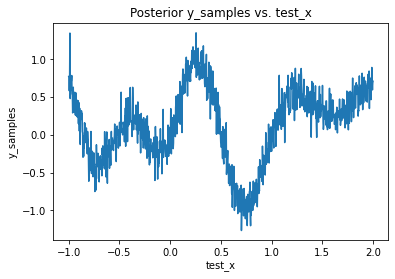

In [43]:
plt.plot(test_x.detach().cpu(), y_samples[0].squeeze().detach().cpu())
plt.xlabel('test_x')
plt.ylabel('y_samples')
plt.title('Posterior y_samples vs. test_x')
plt.show()


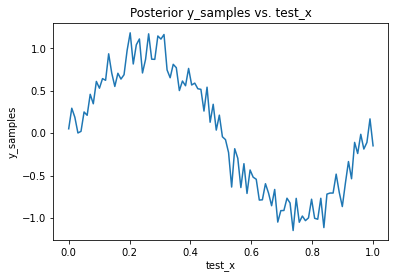

In [44]:
plt.plot(train_x.cpu(), train_y.cpu())
plt.xlabel('test_x')
plt.ylabel('y_samples')
plt.title('Posterior y_samples vs. test_x')
plt.show()

In [8]:
y_samples.shape, observed_pred._extended_shape(torch.Size([31]))

(torch.Size([31, 1000, 1]), torch.Size([31, 1000, 1]))

In [9]:
test_x.dim()

1

In [19]:
from torch.distributions import Uniform, Normal, Independent, Distribution

OBSERVATION_NOISE = False
METHOD = 1
DIMENSION = 4

train_X = torch.rand(4, 0, DIMENSION)
train_Y = torch.rand(4, 0, 1)
# model = SingleTaskGP(train_X, train_Y, likelihood=likelihood, covar_module=kernel)
model = SingleTaskGP(train_X, train_Y)

# test_x = torch.linspace(-1, 2, test_n)
# if torch.cuda.is_available():
#     test_x = test_x.cuda()
# test_x = test_x.unsqueeze(0).unsqueeze(-1)

dimension = 4
m = Uniform(torch.zeros(dimension), torch.ones(dimension))
xvalue_distribution = Independent(m, 1)

test_x = xvalue_distribution.sample(torch.Size([100]))

print(test_x.shape)

if METHOD == 1: # torch.Size([31, 1, 1000, 1])
    # method 1 (BoTorch specific):
    prior = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)
elif METHOD == 2: # torch.Size([31, 1, 1000])
    # method 2 (BoTorch specific):
    prior = model.forward(test_x)
    if OBSERVATION_NOISE:
        prior = model.likelihood(prior)
else: # torch.Size([31, 1, 1000])
    # method 3 (GPyTorch):
    model.eval()
    with gpytorch.settings.prior_mode(True):
        prior = model(test_x)
        if OBSERVATION_NOISE:
            prior = model.likelihood(prior)

prior_samples = prior.sample(torch.Size([1]))

print(type(prior), prior_samples.shape)
# print(prior_samples[0])

torch.Size([100, 4])
<class 'botorch.posteriors.gpytorch.GPyTorchPosterior'> torch.Size([1, 4, 100, 1])


In [17]:
prior_samples.squeeze().shape

torch.Size([4, 1000])

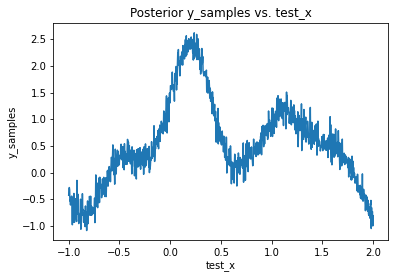

In [52]:
plt.plot(test_x.detach().cpu(), prior_samples[0].squeeze().detach().cpu())
plt.xlabel('test_x')
plt.ylabel('y_samples')
plt.title('Posterior y_samples vs. test_x')
plt.show()

In [140]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-3.3713], requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0.0086, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.2176, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-1.1142]], requires_grad=True))]

In [21]:
# Based on
# https://docs.gpytorch.ai/en/stable/_modules/gpytorch/module.html#Module.initialize
def get_param_value(module, name):
    if "." in name:
        submodule, name = module._get_module_and_name(name)
        if isinstance(submodule, torch.nn.ModuleList):
            idx, name = name.split(".", 1)
            return get_param_value(submodule[int(idx)], name)
        else:
            return get_param_value(submodule, name)
    elif not hasattr(module, name):
        raise AttributeError("Unknown parameter {p} for {c}".format(p=name, c=module.__class__.__name__))
    elif name not in module._parameters and name not in module._buffers:
        return getattr(module, name)
    else:
        return module.__getattr__(name)

In [52]:
## Test sampling from prior
from gpytorch.priors.torch_priors import GammaPrior, UniformPrior, LogNormalPrior
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from botorch.models.utils.gpytorch_modules import get_matern_kernel_with_gamma_prior, get_gaussian_likelihood_with_gamma_prior

DIMENSION = 5
BATCHSIZE = 1

train_X = torch.empty(BATCHSIZE, 0, DIMENSION) # (nbatch, ndatapoints, dimension)
train_Y = torch.empty(BATCHSIZE, 0, 1)         # (nbatch, ndatapoints, noutputs)

# Let's just use the default covar and priors for covar and likelihood for now
# They are given in get_matern_kernel_with_gamma_prior and get_gaussian_likelihood_with_gamma_prior
# https://github.com/pytorch/botorch/blob/main/botorch/models/utils/gpytorch_modules.py
# https://botorch.org/api/_modules/botorch/models/gp_regression.html#SingleTaskGP
model = SingleTaskGP(train_X, train_Y)


# # We will use the simplest form of GP model, exact inference
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# # initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModel(train_X, train_Y, likelihood)

# # https://github.com/cornellius-gp/gpytorch/issues/681
# # https://github.com/cornellius-gp/gpytorch/pull/918
# # Register normal GPyTorch priors
# model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
# model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.2), "lengthscale")
# model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
# likelihood.register_prior("noise_prior", LogNormalPrior(-1.5, 0.1), "noise")


# Currently the parameters are set to their default values, as we can see:
print("Before sample from prior")
for name, param in model.named_parameters():
    print(name, param)
print("outputscale:", model.covar_module.outputscale)
print("lengthscale:", model.covar_module.base_kernel.lengthscale)


# for some reason, after calling pyro_sample_from_prior, the parameters() and named_parameters() return empty !
# So let's save them before they go away
model_parameters = list(model.named_parameters())

# Now let's sample from the prior
model = model.pyro_sample_from_prior() # need to set equal

print("\nAfter sample from prior")
# print("sampled lengthscale:", model.covar_module.base_kernel.raw_lengthscale) ## OK, IT WORKS!!

# print('=====')
# for name, param in model._parameters:
#     print(param)
# print('=====')

print()

for name, param in model_parameters: 
    # print(name, param)
    print(name)
    print(get_param_value(model, name))
    print()


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


Before sample from prior
likelihood.noise_covar.raw_noise Parameter containing:
tensor([[2.0000]], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor([0.], requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor([0.], requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[[0., 0., 0., 0., 0.]]], requires_grad=True)
outputscale: tensor([0.6931], grad_fn=<SoftplusBackward0>)
lengthscale: tensor([[[0.6931, 0.6931, 0.6931, 0.6931, 0.6931]]],
       grad_fn=<SoftplusBackward0>)

After sample from prior

likelihood.noise_covar.raw_noise
tensor([[32.0134]])

mean_module.raw_constant
Parameter containing:
tensor([0.], requires_grad=True)

covar_module.raw_outputscale
tensor([6.7164])

covar_module.base_kernel.raw_lengthscale
tensor([[[-0.1403, -1.8673, -1.5420,  0.1838,  0.7615]]])



In [76]:
model._aug_batch_shape

torch.Size([3, 8])

In [61]:
model.covar_module.base_kernel.raw_lengthscale.shape

torch.Size([1, 1, 2])

In [134]:
a = torch.tensor([1, 2, 3, 4])
p = torch.tensor([0.1, 0.1, 0.1, 0.7])
n = 1
replace = True

idx = p.multinomial(num_samples=n, replacement=replace)
# idx = torch.multinomial(p, num_samples=n, replacement=True)
b = a[idx]

print(idx[0].numpy())
print(b)

3
tensor([4])


In [101]:
idx

tensor([2, 0])

In [139]:
u = ["fuc","me"]
u[torch.tensor([0,1,1,0])]

TypeError: only integer tensors of a single element can be converted to an index

In [38]:
train_X = torch.rand(20, 2)
train_Y = (torch.sin(train_X[:, 0]) + torch.cos(train_X[:, 1])).unsqueeze(1)
model = SingleTaskGP(train_X, train_Y)
new_X = torch.rand(5, 2)
new_Y = (torch.sin(new_X[:, 0]) + torch.cos(new_X[:, 1])).unsqueeze(1)
model = model.condition_on_observations(X=new_X, Y=new_Y)

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2812]), std = tensor([0.3005])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


RuntimeError: Fantasy observations can only be added after making predictions with a model so that all test independent caches exist. Call the model on some data first!

In [35]:
train_X = torch.rand(20, 2)
train_Y = torch.cat(
    [torch.sin(train_X[:, 0]), torch.cos(train_X[:, 1])], -1
).unsqueeze(1)
model = SingleTaskGP(train_X, train_Y)
new_X = torch.rand(5, 2)
new_Y = torch.cat([torch.sin(new_X[:, 0]), torch.cos(new_X[:, 1])], -1).unsqueeze(1)
model = model.condition_on_observations(X=new_X, Y=new_Y)

/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6176]), std = tensor([0.2620])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


RuntimeError: Fantasy observations can only be added after making predictions with a model so that all test independent caches exist. Call the model on some data first!

In [31]:
train_X = torch.rand(20, 2)
train_Y = torch.cat(
    [torch.sin(train_X[:, 0]), torch.cos(train_X[:, 1])], -1
)

train_Y.shape

torch.Size([40])

In [45]:
from botorch.models.gp_regression import SingleTaskGP
train_X = torch.rand(20, 2)
train_Y = torch.cat(
    [torch.sin(train_X[:, 0]), torch.cos(train_X[:, 1])], -1).unsqueeze(1)
model = SingleTaskGP(train_X, train_Y)

print("Before sample from prior")
for name, param in model.named_parameters():
    print(name, param)

model = model.pyro_sample_from_prior()

print("\nAfter sample from prior")
for name, param in model.named_parameters():
    print(name, param)

print("Parameters are missing!")
print("sampled lengthscale:", model.covar_module.base_kernel.raw_lengthscale)

Before sample from prior
likelihood.noise_covar.raw_noise Parameter containing:
tensor([2.0000], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0., 0.]], requires_grad=True)

After sample from prior
mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)
Parameters are missing!
sampled lengthscale: tensor([[ 0.4932, -0.4163]])


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6874]), std = tensor([0.2618])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [46]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_X = torch.rand(20, 2)
train_Y = torch.cat([torch.sin(train_X[:, 0]), torch.cos(train_X[:, 1])], -1)
model = ExactGPModel(train_X, train_Y, gpytorch.likelihoods.GaussianLikelihood())
new_X = torch.rand(5, 2)
new_Y = torch.cat([torch.sin(new_X[:, 0]), torch.cos(new_X[:, 1])], -1)
model = model.get_fantasy_model(new_X, new_Y)

RuntimeError: Fantasy observations can only be added after making predictions with a model so that all test independent caches exist. Call the model on some data first!

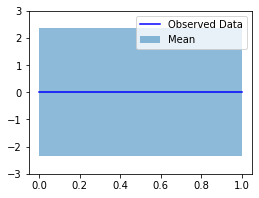

In [51]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(None, None, likelihood)
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])